In [1]:
# Import libraries
import pandas as pd
import duckdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

In [2]:
# Connect to the database
con = duckdb.connect(database='icu_outcomes.duckdb')

# Load the table into a pandas DataFrame
df = con.execute("SELECT * FROM clean_data").fetchdf()

# Close the connection
con.close()

# Display the first few rows of the DataFrame
display(df.head())

,gender,admission_date,discharge_date,diagnosis,age_numeric,marital_status,religion,comorbidities,referral,referral_others_specify,...,surgery_before_during_admission,urinary_catheter,peripheral_catheter,central_venous_catheter,intubation,ng_tube,chest_tube,mortality,intubated,gcs_cleaned
0,Female,2022-04-08,2022-04-15,I31.3 - Pericardial effusion (noninflammatory)...,16,Never married/not in union,Christianity,Non-communicable,Others (specify),None,...,False,True,True,True,True,True,False,True,<NA>,<NA>
1,Female,2023-02-25,2023-03-02,"O15.2 - Eclampsia in the puerperium, D57.219 -...",26,Never married/not in union,Christianity,Non-communicable,O&G,None,...,True,True,True,False,False,False,False,False,False,15
2,Male,2021-01-27,2021-01-27,S06.5 - Traumatic subdural haemorrhage,40,Currently married/in union,Christianity,Non-communicable,MSW,None,...,False,True,True,False,True,True,False,True,False,3
3,Male,2021-05-24,2021-05-31,"I64 - Stroke, not specified as haemorrhage or ...",77,None,None,None,None,None,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Female,2021-05-10,2021-05-15,"A02.1 - Salmonella sepsis, ASUR06A - Laparotom...",16,Never married/not in union,Christianity,Non-communicable,Main Theater Recovery Ward,None,...,True,True,True,True,True,True,False,True,False,14


In [3]:
# Remove records with null mortality
df = df.dropna(subset=['mortality'])

# Convert date columns to datetime objects
df['admission_date'] = pd.to_datetime(df['admission_date'])
df['discharge_date'] = pd.to_datetime(df['discharge_date'])

# Calculate length of stay in days
df['length_of_stay_days'] = (df['discharge_date'] - df['admission_date']).dt.days

# Display the first few rows of the cleaned DataFrame and info
display(df.head())
display(df.info())

,gender,admission_date,discharge_date,diagnosis,age_numeric,marital_status,religion,comorbidities,referral,referral_others_specify,...,urinary_catheter,peripheral_catheter,central_venous_catheter,intubation,ng_tube,chest_tube,mortality,intubated,gcs_cleaned,length_of_stay_days
0,Female,2022-04-08,2022-04-15,I31.3 - Pericardial effusion (noninflammatory)...,16,Never married/not in union,Christianity,Non-communicable,Others (specify),None,...,True,True,True,True,True,False,True,<NA>,<NA>,7
1,Female,2023-02-25,2023-03-02,"O15.2 - Eclampsia in the puerperium, D57.219 -...",26,Never married/not in union,Christianity,Non-communicable,O&G,None,...,True,True,False,False,False,False,False,False,15,5
2,Male,2021-01-27,2021-01-27,S06.5 - Traumatic subdural haemorrhage,40,Currently married/in union,Christianity,Non-communicable,MSW,None,...,True,True,False,True,True,False,True,False,3,0
4,Female,2021-05-10,2021-05-15,"A02.1 - Salmonella sepsis, ASUR06A - Laparotom...",16,Never married/not in union,Christianity,Non-communicable,Main Theater Recovery Ward,None,...,True,True,True,True,True,False,True,False,14,5
5,Male,2021-06-15,2021-07-02,"K3589 - Other acute appendicitis, K3589 - Othe...",81,Currently married/in union,Christianity,Non-communicable,Main Theater Recovery Ward,None,...,True,True,True,True,True,True,True,False,15,17


<class 'pandas.core.frame.DataFrame'>
Index: 636 entries, 0 to 653
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   gender                           636 non-null    object        
 1   admission_date                   636 non-null    datetime64[us]
 2   discharge_date                   636 non-null    datetime64[us]
 3   diagnosis                        636 non-null    object        
 4   age_numeric                      636 non-null    int64         
 5   marital_status                   514 non-null    object        
 6   religion                         497 non-null    object        
 7   comorbidities                    511 non-null    object        
 8   referral                         579 non-null    object        
 9   referral_others_specify          32 non-null     object        
 10  antibiotic_treatment             586 non-null    boolean       
 11

None

In [4]:
# Identify missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
print("\nMissing Values:")
print(missing_values)
print("\nMissing Value Percentage:")
print(missing_percentage)


Missing Values:
gender                               0
admission_date                       0
discharge_date                       0
diagnosis                            0
age_numeric                          0
marital_status                     122
religion                           139
comorbidities                      125
referral                            57
referral_others_specify            604
antibiotic_treatment                50
surgery_before_during_admission      8
urinary_catheter                    38
peripheral_catheter                 30
central_venous_catheter             33
intubation                          24
ng_tube                             26
chest_tube                          24
mortality                            0
intubated                          151
gcs_cleaned                        164
length_of_stay_days                  0
dtype: int64

Missing Value Percentage:
gender                              0.000000
admission_date                      0.00

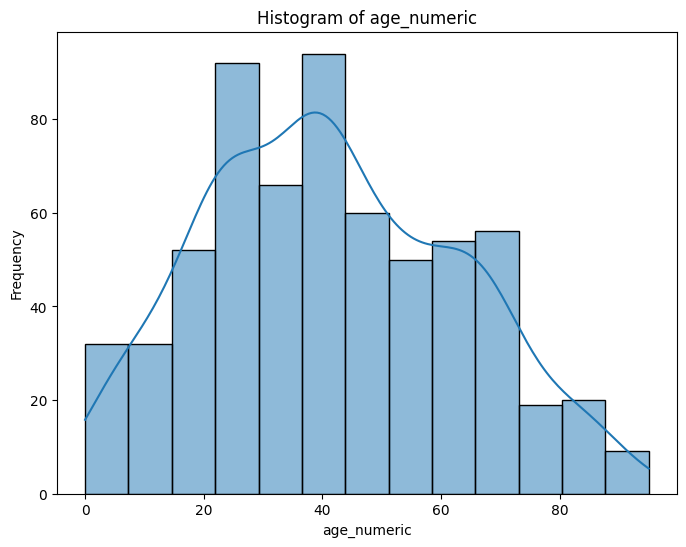

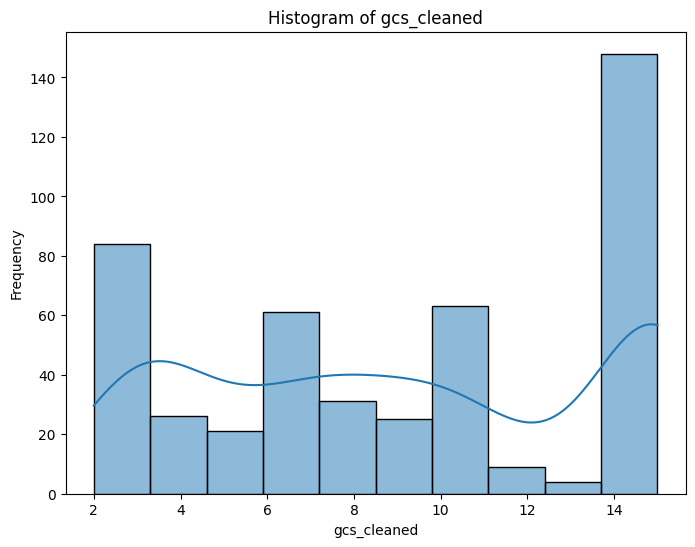

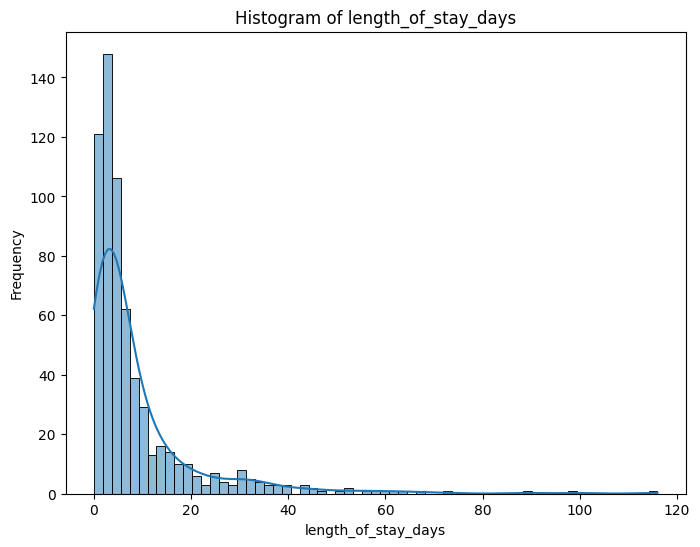

In [5]:
# Histogram of numeric variables
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.show()

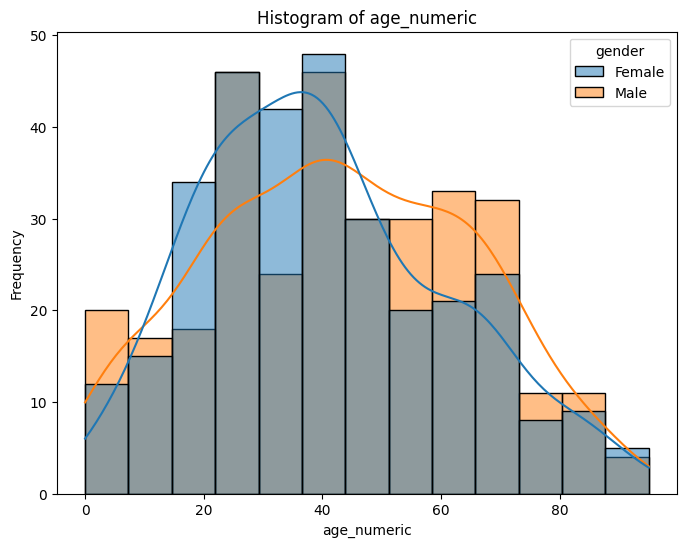

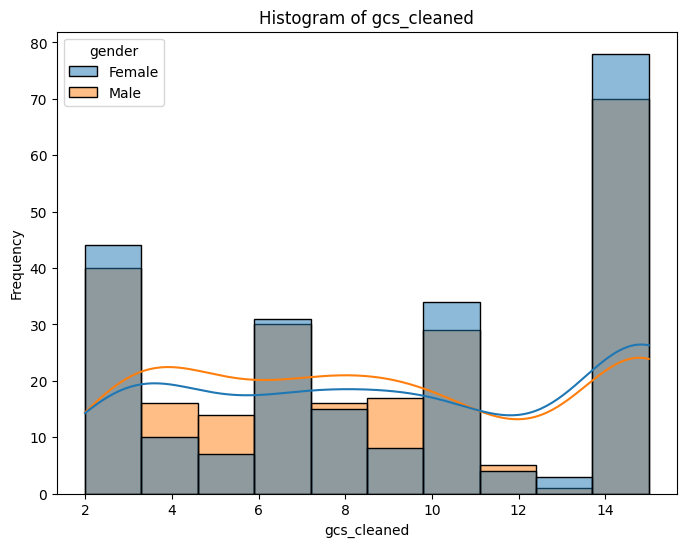

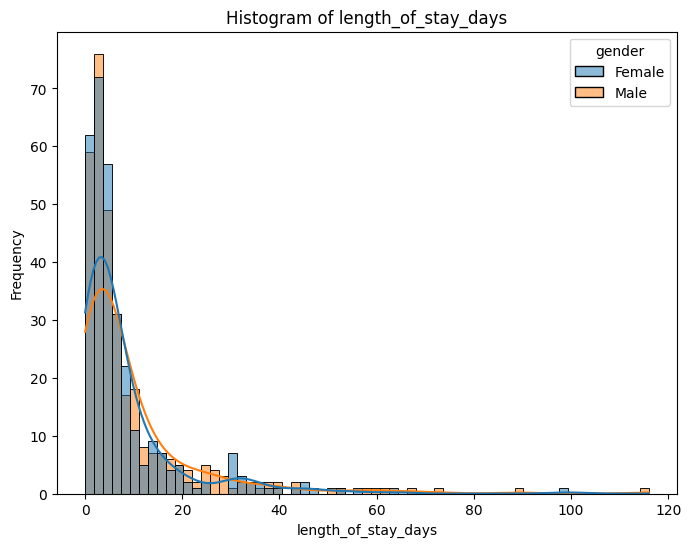

In [6]:
# Histogram of numeric variables by sex
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, kde=True, hue=df["gender"])
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.show()


Distribution of gender:
gender
Male      322
Female    314
Name: count, dtype: int64

Distribution of diagnosis:
diagnosis
S06.5 - Traumatic subdural haemorrhage                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

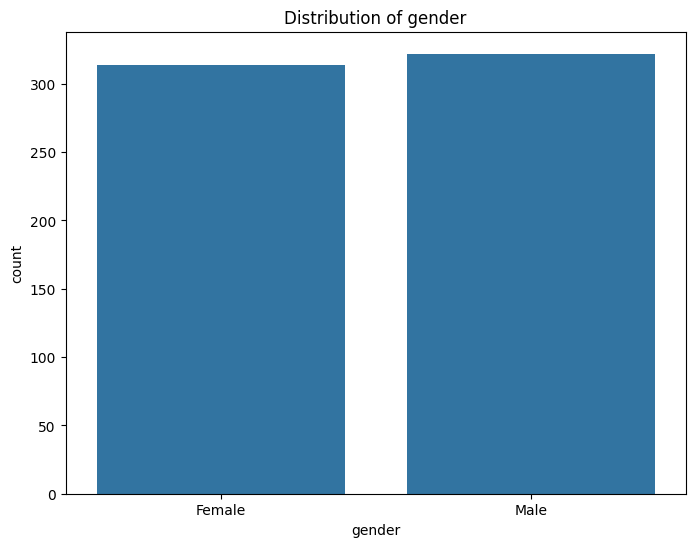

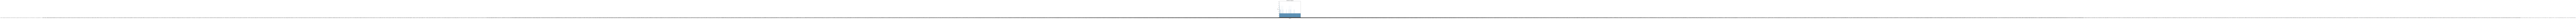

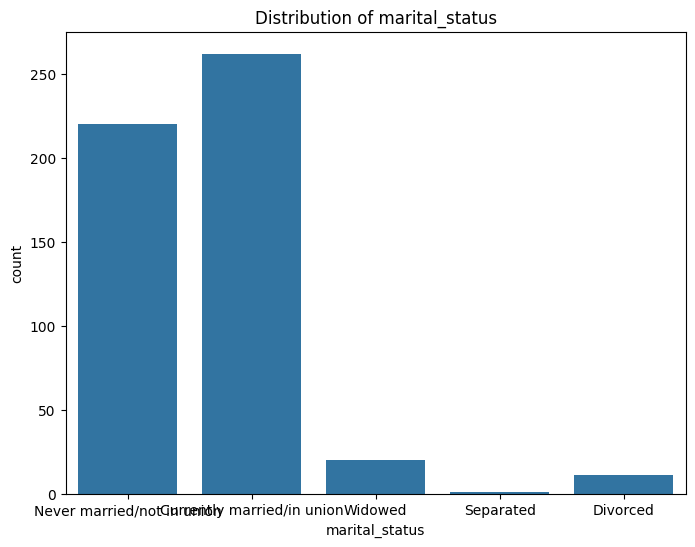

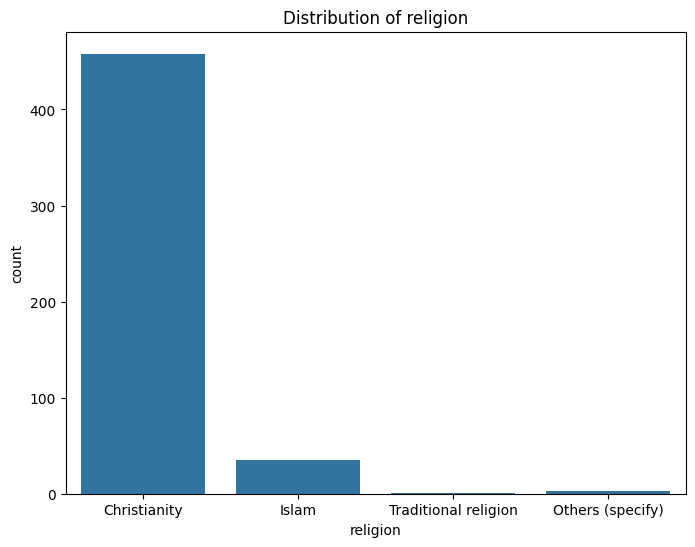

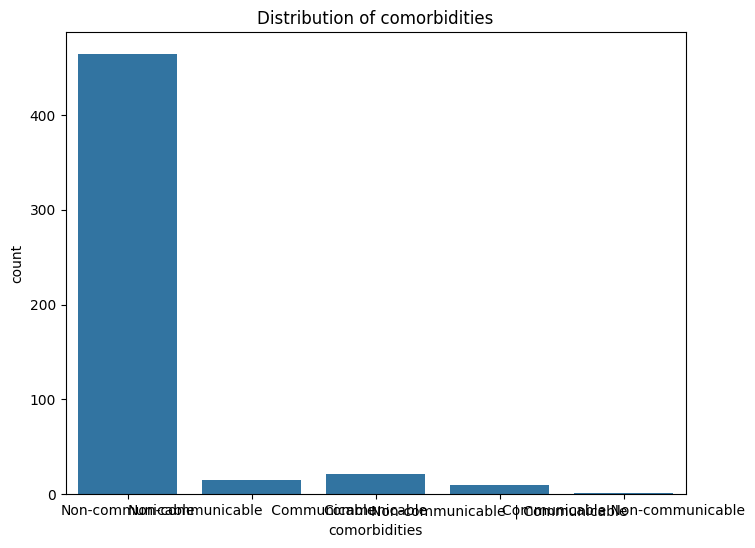

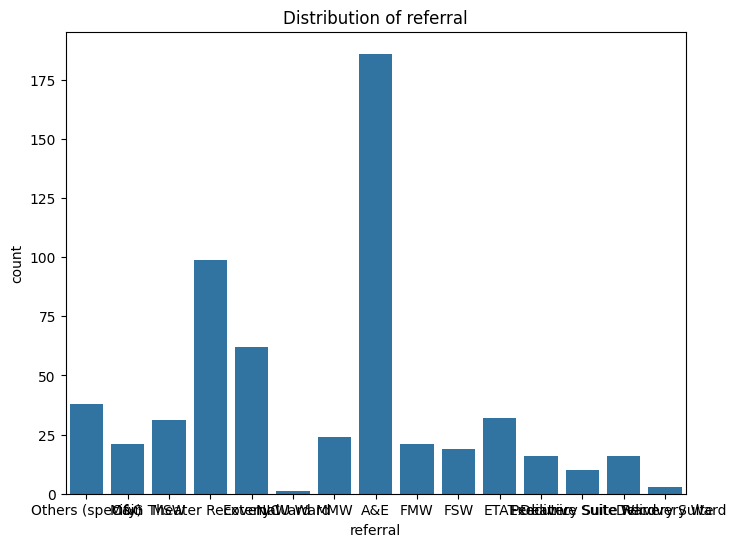

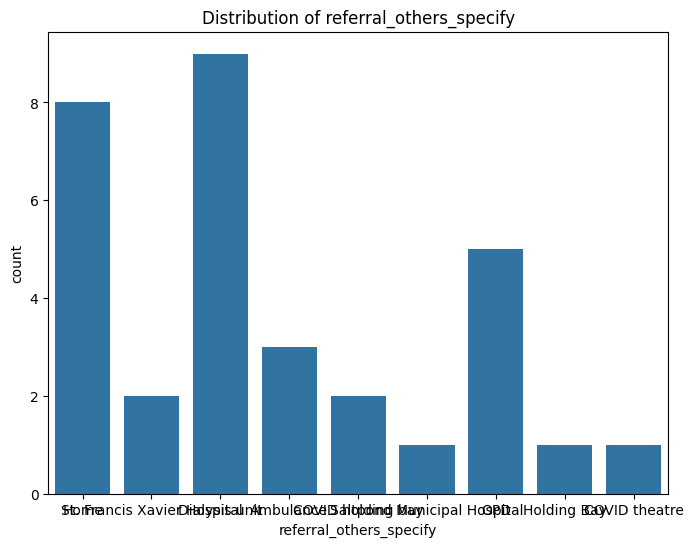

In [7]:
# Analyze the distribution of categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts())
    # Bar plot
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')

,age_numeric,antibiotic_treatment,surgery_before_during_admission,urinary_catheter,peripheral_catheter,central_venous_catheter,intubation,ng_tube,chest_tube,mortality,intubated,gcs_cleaned,length_of_stay_days
age_numeric,1.000000,-0.014691,-0.025268,0.088711,0.051374,0.072964,-0.098974,-0.079273,-0.006860,-0.017263,-0.013986,0.074692,-0.085991
antibiotic_treatment,-0.014691,1.000000,0.236698,0.124617,0.031686,0.108108,0.116204,0.199217,0.057633,-0.007268,0.159925,-0.117221,0.101533
surgery_before_during_admission,-0.025268,0.236698,1.000000,0.130836,0.008488,0.108326,0.055483,0.246887,0.052021,-0.091982,0.168262,-0.049948,0.162854
urinary_catheter,0.088711,0.124617,0.130836,1.000000,0.284382,0.100863,0.121064,0.195299,0.027378,0.061359,0.117829,0.047975,0.067352
peripheral_catheter,0.051374,0.031686,0.008488,0.284382,1.000000,-0.180207,0.046443,0.027210,0.019343,-0.001481,0.057672,0.059769,-0.036676
central_venous_catheter,0.072964,0.108108,0.108326,0.100863,-0.180207,1.000000,0.222207,0.170338,0.082490,0.128849,0.130913,-0.032796,0.271419
intubation,-0.098974,0.116204,0.055483,0.121064,0.046443,0.222207,1.000000,0.397274,0.034389,0.271536,0.250927,-0.430937,0.136827
ng_tube,-0.079273,0.199217,0.246887,0.195299,0.027210,0.170338,0.397274,1.000000,0.072279,0.224503,0.242659,-0.369220,0.141003
chest_tube,-0.006860,0.057633,0.052021,0.027378,0.019343,0.082490,0.034389,0.072279,1.000000,-0.038053,-0.001076,0.116179,0.092687
mortality,-0.017263,-0.007268,-0.091982,0.061359,-0.001481,0.128849,0.271536,0.224503,-0.038053,1.000000,0.138546,-0.402792,0.035095


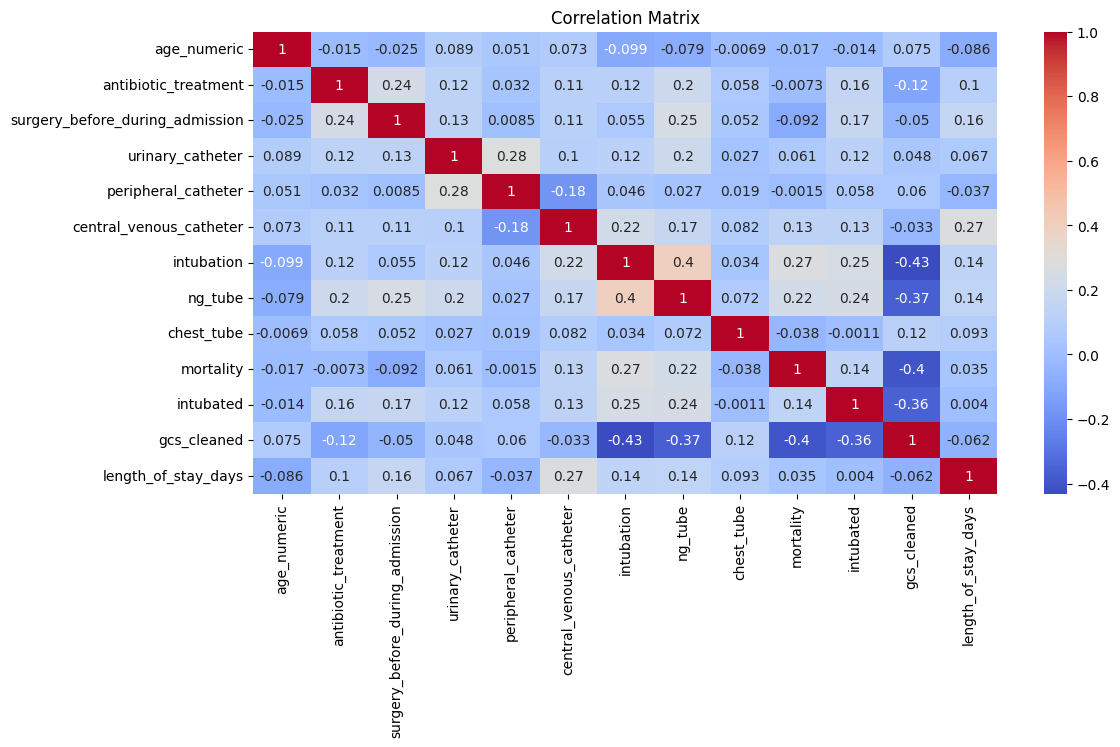

In [8]:
# Investigate the correlation between numerical features
correlation_matrix = df.corr(numeric_only=True)
display(correlation_matrix)

# Plot correlation matrix
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

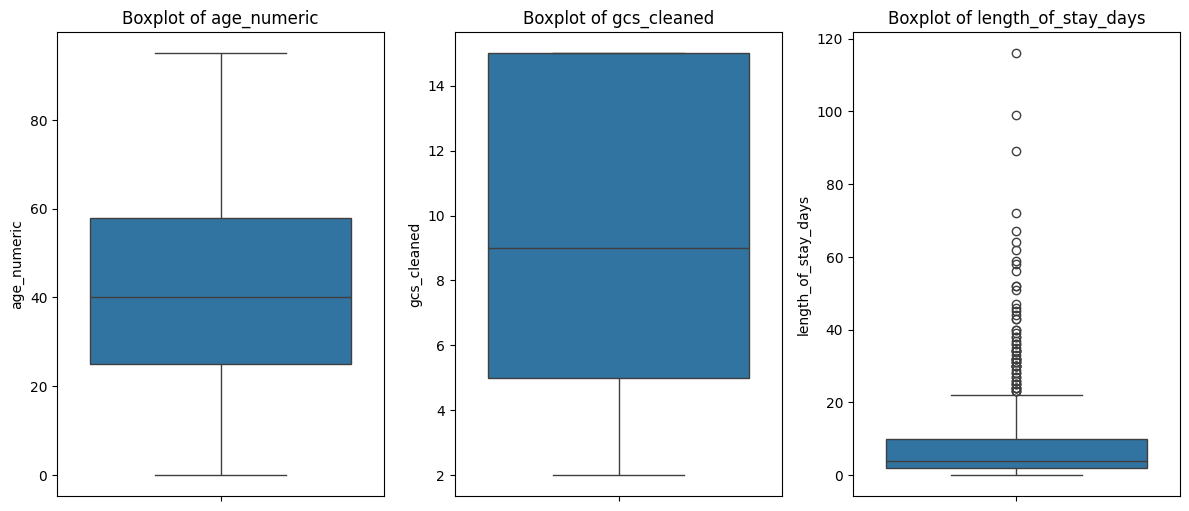

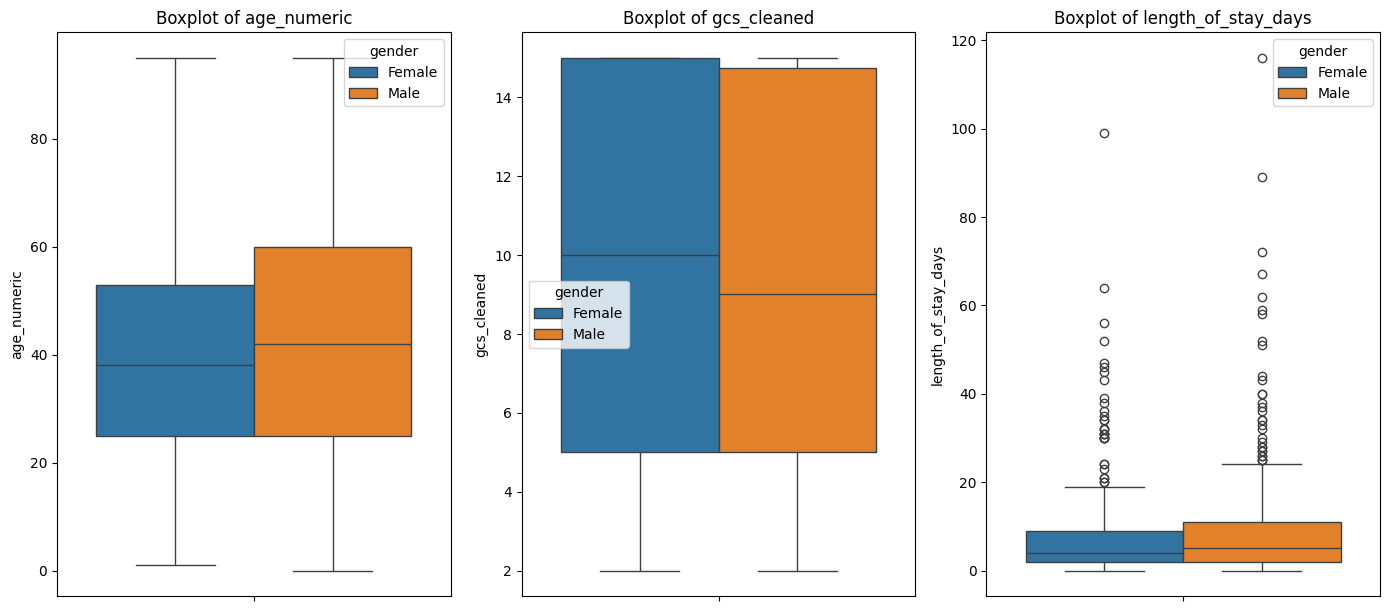

In [9]:
# Identify potential outliers
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Box plot stratified by sex
plt.figure(figsize=(14, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col], hue=df["gender"])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [10]:
# Calculate overall mortality prevalence
overall_mortality_prevalence = df['mortality'].mean()
print(f"Overall Mortality Prevalence: {overall_mortality_prevalence:.2f}")

Overall Mortality Prevalence: 0.45



Mortality by Gender:


mortality,False,True
gender,,
Female,0.544586,0.455414
Male,0.555901,0.444099



Age Distribution by Mortality:


,count,mean,std,min,25%,50%,75%,max
mortality,,,,,,,,
False,350.0,41.880000,21.596917,1.0,25.0,40.0,56.00,95.0
True,286.0,41.136364,21.291105,0.0,25.0,40.0,58.75,95.0


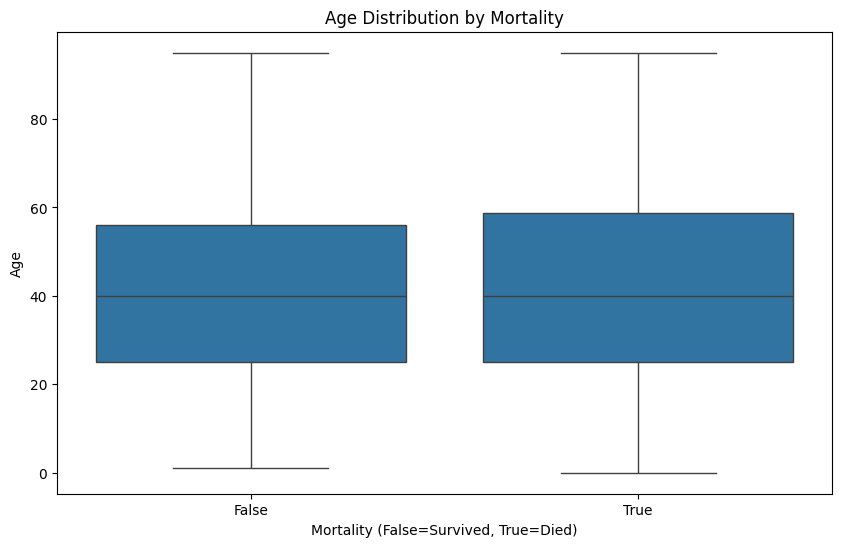


Mortality by Referral Source:


mortality,False,True
referral,,
ETAT,0.343750,0.656250
FSW,0.368421,0.631579
A&E,0.489247,0.510753
MSW,0.516129,0.483871
External,0.516129,0.483871
FMW,0.523810,0.476190
Pediatric,0.562500,0.437500
Main Theater Recovery Ward,0.585859,0.414141
MMW,0.625000,0.375000



Mortality by Clinical Characteristics:

antibiotic_treatment:


mortality,False,True
antibiotic_treatment,,
False,0.555556,0.444444
True,0.564854,0.435146



surgery_before_during_admission:


mortality,False,True
surgery_before_during_admission,,
False,0.501661,0.498339
True,0.593272,0.406728



urinary_catheter:


mortality,False,True
urinary_catheter,,
False,0.649123,0.350877
True,0.545287,0.454713



peripheral_catheter:


mortality,False,True
peripheral_catheter,,
False,0.554745,0.445255
True,0.556503,0.443497



central_venous_catheter:


mortality,False,True
central_venous_catheter,,
False,0.600998,0.399002
True,0.465347,0.534653



intubation:


mortality,False,True
intubation,,
False,0.737089,0.262911
True,0.453634,0.546366



ng_tube:


mortality,False,True
ng_tube,,
False,0.745223,0.254777
True,0.490066,0.509934



chest_tube:


mortality,False,True
chest_tube,,
False,0.552677,0.447323
True,0.636364,0.363636



intubated:


mortality,False,True
intubated,,
False,0.590395,0.409605
True,0.435115,0.564885



GCS Distribution by Mortality:


,count,mean,std,min,25%,50%,75%,max
mortality,,,,,,,,
False,259.0,10.888031,4.165079,2.0,7.0,11.0,15.0,15.0
True,213.0,7.173709,4.261816,2.0,3.0,6.0,10.0,15.0


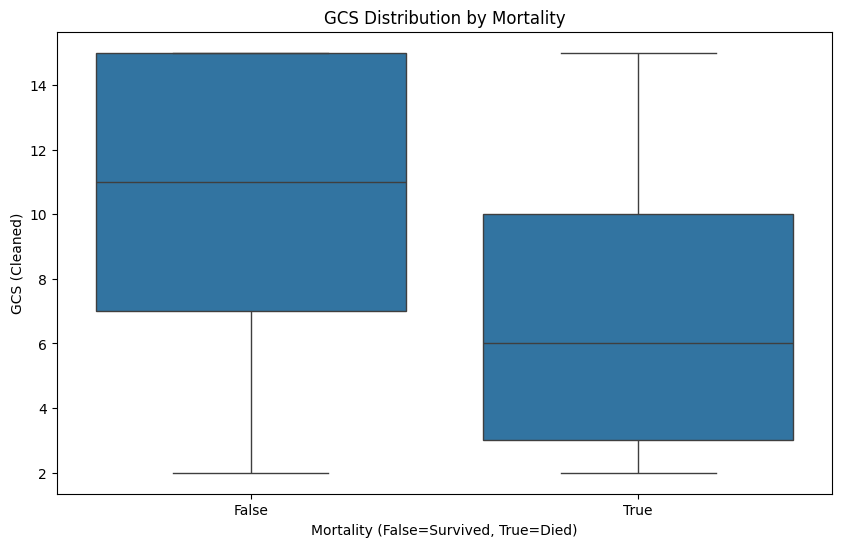

In [11]:
# Relationship between mortality and gender
print("\nMortality by Gender:")
mortality_by_gender = pd.crosstab(df['gender'], df['mortality'], normalize='index')
display(mortality_by_gender)

# Relationship between mortality and age group (need to define age groups first)
# For now, compare age distribution for deceased vs. survived
print("\nAge Distribution by Mortality:")
display(df.groupby('mortality')['age_numeric'].describe())

# Visualize age distribution by mortality
plt.figure(figsize=(10, 6))
sns.boxplot(x='mortality', y='age_numeric', data=df)
plt.title('Age Distribution by Mortality')
plt.xlabel('Mortality (False=Survived, True=Died)')
plt.ylabel('Age')
plt.show()

# Relationship between mortality and referral source
print("\nMortality by Referral Source:")
mortality_by_referral = pd.crosstab(df['referral'], df['mortality'], normalize='index')
display(mortality_by_referral.sort_values(by=True, ascending=False)) # Sort by mortality rate

# Relationship between mortality and selected clinical characteristics (boolean columns)
clinical_vars = ['antibiotic_treatment', 'surgery_before_during_admission',
                 'urinary_catheter', 'peripheral_catheter', 'central_venous_catheter',
                 'intubation', 'ng_tube', 'chest_tube', 'intubated']

print("\nMortality by Clinical Characteristics:")
for var in clinical_vars:
    if var in df.columns:
        print(f"\n{var}:")
        mortality_by_clinical = pd.crosstab(df[var], df['mortality'], normalize='index')
        display(mortality_by_clinical)

# Explore relationship with GCS (cleaned)
print("\nGCS Distribution by Mortality:")
display(df.groupby('mortality')['gcs_cleaned'].describe())

# Visualize GCS distribution by mortality
plt.figure(figsize=(10, 6))
sns.boxplot(x='mortality', y='gcs_cleaned', data=df)
plt.title('GCS Distribution by Mortality')
plt.xlabel('Mortality (False=Survived, True=Died)')
plt.ylabel('GCS (Cleaned)')
plt.show()


Length of Stay Distribution by Mortality:


,count,mean,std,min,25%,50%,75%,max
mortality,,,,,,,,
False,350.0,8.234286,11.312035,0.0,2.0,4.0,9.0,89.0
True,286.0,9.125874,14.116740,0.0,2.0,4.0,11.0,116.0


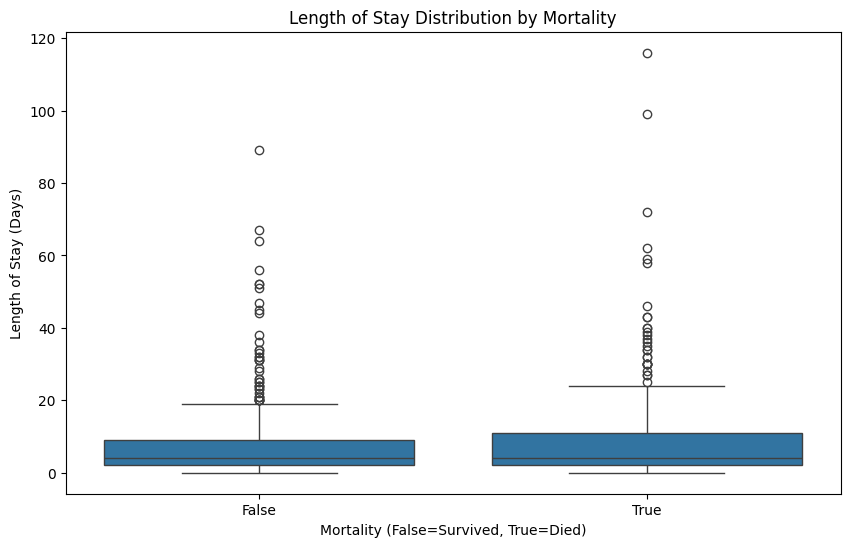


Mean Length of Stay by Gender:


,length_of_stay_days
gender,
Female,7.964968
Male,9.288820



Correlation between Length of Stay and Age:


,length_of_stay_days,age_numeric
length_of_stay_days,1.000000,-0.085991
age_numeric,-0.085991,1.000000


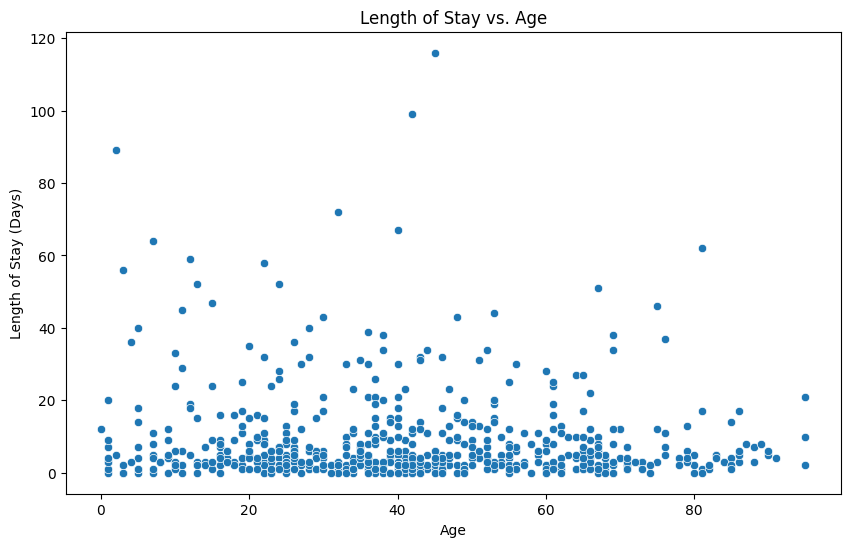


Mean Length of Stay by Clinical Characteristics:

antibiotic_treatment:


,length_of_stay_days
antibiotic_treatment,
False,6.277778
True,9.663180



surgery_before_during_admission:


,length_of_stay_days
surgery_before_during_admission,
False,6.518272
True,10.654434



urinary_catheter:


,length_of_stay_days
urinary_catheter,
False,6.245614
True,9.184843



peripheral_catheter:


,length_of_stay_days
peripheral_catheter,
False,9.642336
True,8.526652



central_venous_catheter:


,length_of_stay_days
central_venous_catheter,
False,6.376559
True,13.702970



intubation:


,length_of_stay_days
intubation,
False,6.389671
True,10.047619



ng_tube:


,length_of_stay_days
ng_tube,
False,5.796178
True,9.931567



chest_tube:


,length_of_stay_days
chest_tube,
False,8.476684
True,13.696970



intubated:


,length_of_stay_days
intubated,
False,9.423729
True,9.549618



Correlation between Length of Stay and GCS (cleaned):


,length_of_stay_days,gcs_cleaned
length_of_stay_days,1.00000,-0.06234
gcs_cleaned,-0.06234,1.00000


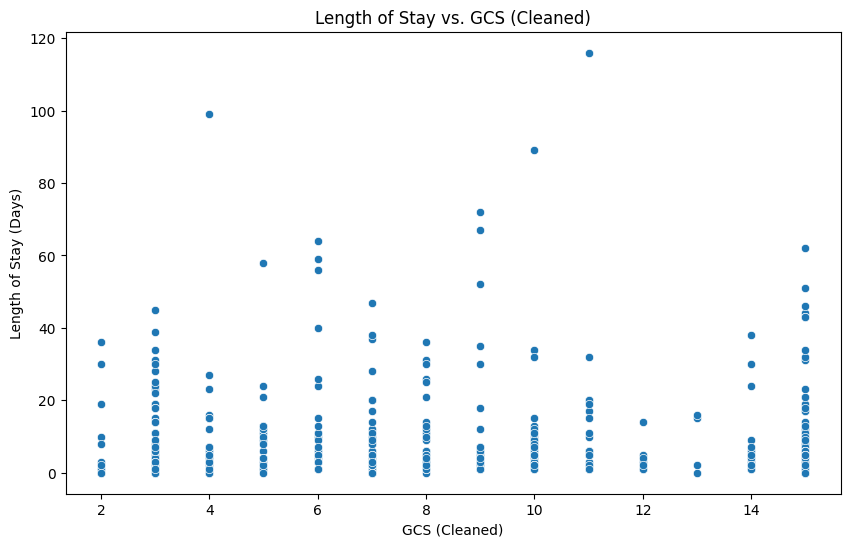

In [12]:
# Relationship between length of stay and mortality
print("\nLength of Stay Distribution by Mortality:")
display(df.groupby('mortality')['length_of_stay_days'].describe())

# Visualize length of stay distribution by mortality
plt.figure(figsize=(10, 6))
sns.boxplot(x='mortality', y='length_of_stay_days', data=df)
plt.title('Length of Stay Distribution by Mortality')
plt.xlabel('Mortality (False=Survived, True=Died)')
plt.ylabel('Length of Stay (Days)')
plt.show()

# Relationship between length of stay and gender
print("\nMean Length of Stay by Gender:")
display(df.groupby('gender')['length_of_stay_days'].mean())

# Relationship between length of stay and age group (need to define age groups first)
# For now, examine correlation with numerical age
print("\nCorrelation between Length of Stay and Age:")
display(df[['length_of_stay_days', 'age_numeric']].corr())

# Visualize relationship between length of stay and age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age_numeric', y='length_of_stay_days', data=df)
plt.title('Length of Stay vs. Age')
plt.xlabel('Age')
plt.ylabel('Length of Stay (Days)')
plt.show()


# Relationship between length of stay and selected clinical characteristics (boolean columns)
print("\nMean Length of Stay by Clinical Characteristics:")
for var in clinical_vars:
    if var in df.columns:
        print(f"\n{var}:")
        display(df.groupby(var)['length_of_stay_days'].mean())

# Relationship between length of stay and GCS (cleaned)
print("\nCorrelation between Length of Stay and GCS (cleaned):")
display(df[['length_of_stay_days', 'gcs_cleaned']].corr())

# Visualize relationship between length of stay and GCS (cleaned)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gcs_cleaned', y='length_of_stay_days', data=df)
plt.title('Length of Stay vs. GCS (Cleaned)')
plt.xlabel('GCS (Cleaned)')
plt.ylabel('Length of Stay (Days)')
plt.show()

In [13]:
from scipy.stats import ttest_ind, chi2_contingency

# Hypothesis Test 1: GCS vs. Mortality (Independent Samples t-test)

# Separate GCS scores for patients who survived (mortality=False) and died (mortality=True)
gcs_survived = df[df['mortality'] == False]['gcs_cleaned'].dropna()
gcs_died = df[df['mortality'] == True]['gcs_cleaned'].dropna()

# Perform independent samples t-test
ttest_result = ttest_ind(gcs_survived, gcs_died)

print("\nIndependent Samples T-test for GCS vs. Mortality:")
print(f"  Test Statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the result
alpha = 0.05
if ttest_result.pvalue < alpha:
    print(f"  Result: Reject the null hypothesis. There is a statistically significant difference in mean GCS scores between patients who survived and those who died (p < {alpha}).")
else:
    print(f"  Result: Fail to reject the null hypothesis. There is no statistically significant difference in mean GCS scores between patients who survived and those who died (p >= {alpha}).")

# Hypothesis Test 2: Referral Source vs. Mortality (Chi-squared test)

# Create a contingency table of referral source and mortality
contingency_table = pd.crosstab(df['referral'], df['mortality'])

# Perform chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-squared Test for Referral Source vs. Mortality:")
print(f"  Chi-squared Statistic: {chi2:.4f}")
print(f"  P-value: {p:.4f}")
print(f"  Degrees of Freedom: {dof}")

# Interpret the result
if p < alpha:
    print(f"  Result: Reject the null hypothesis. There is a statistically significant association between referral source and mortality (p < {alpha}).")
else:
    print(f"  Result: Fail to reject the null hypothesis. There is no statistically significant association between referral source and mortality (p >= {alpha}).")


Independent Samples T-test for GCS vs. Mortality:
  Test Statistic: 9.5405
  P-value: 0.0000
  Result: Reject the null hypothesis. There is a statistically significant difference in mean GCS scores between patients who survived and those who died (p < 0.05).

Chi-squared Test for Referral Source vs. Mortality:
  Chi-squared Statistic: 23.2130
  P-value: 0.0569
  Degrees of Freedom: 14
  Result: Fail to reject the null hypothesis. There is no statistically significant association between referral source and mortality (p >= 0.05).


In [14]:
mask = df["length_of_stay_days"] <= 1
len(df[mask])

121


Mortality by Year:


,admission_year,mortality
0,2019,0.538012
1,2020,0.445161
2,2021,0.40625
3,2022,0.4
4,2023,0.40566


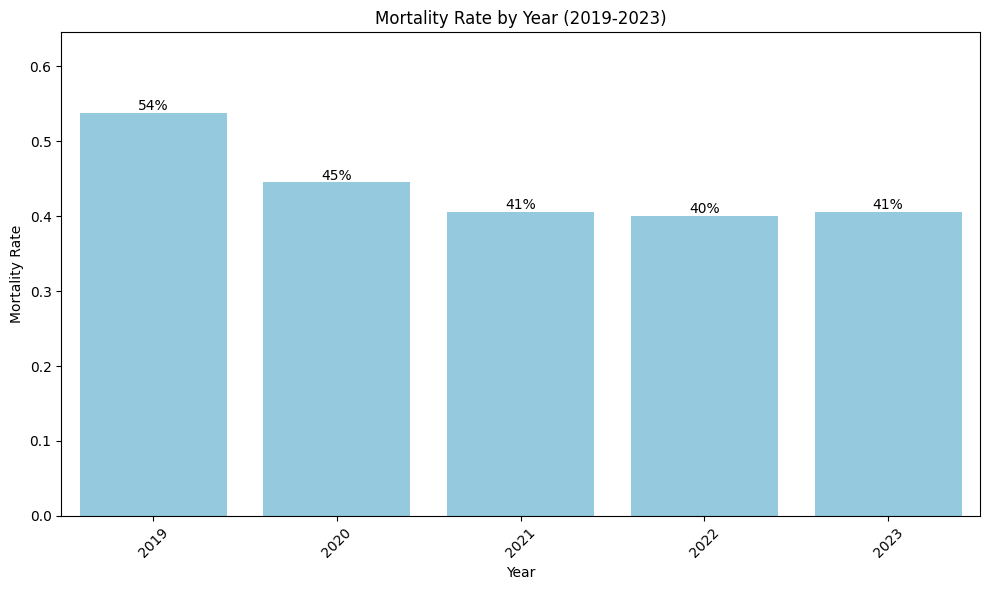


Mortality by Month:


,admission_month,mortality,month_name
0,1,0.596491,Jan
1,2,0.428571,Feb
2,3,0.263158,Mar
3,4,0.433962,Apr
4,5,0.428571,May
5,6,0.489362,Jun
6,7,0.5,Jul
7,8,0.407407,Aug
8,9,0.477612,Sep
9,10,0.431818,Oct


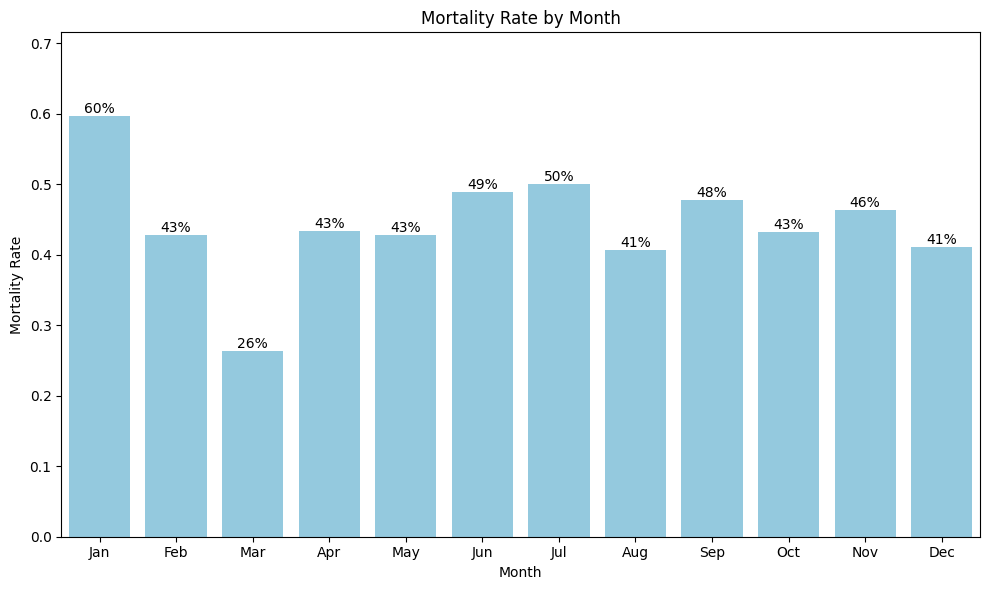


Mortality by Day of the Week:


,admission_dayofweek,mortality
0,0,0.481928
1,1,0.406977
2,2,0.446429
3,3,0.384615
4,4,0.464286
5,5,0.493976
6,6,0.478261


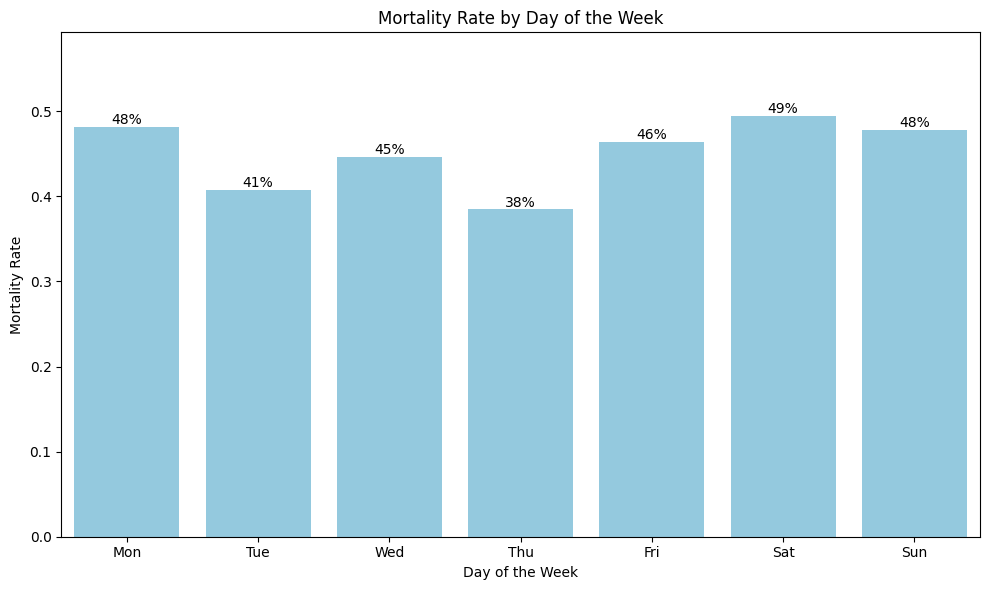

In [27]:
# Extract year, month, and day of the week from admission_date
df['admission_year'] = df['admission_date'].dt.year
df['admission_month'] = df['admission_date'].dt.month
df['admission_dayofweek'] = df['admission_date'].dt.dayofweek # Monday=0, Sunday=6

# Calculate mortality rate by year
mortality_by_year = df.groupby('admission_year')['mortality'].mean().reset_index()

print("\nMortality by Year:")
display(mortality_by_year)

# Visualize mortality by year
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mortality_by_year, x='admission_year', y='mortality', color='skyblue') # Changed to barplot and set color
plt.title('Mortality Rate by Year (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.xticks(ticks=range(len(mortality_by_year)), labels=mortality_by_year['admission_year'], rotation=45) # Set specific ticks and labels for barplot
plt.ylim(0, mortality_by_year['mortality'].max() * 1.2) # Adjusted y-axis limit for labels
plt.tight_layout()
# Add mortality rate values on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

# Calculate mortality rate by month
mortality_by_month = df.groupby('admission_month')['mortality'].mean().reset_index()

# Add month names for proper ordering in the plot
mortality_by_month['month_name'] = pd.to_datetime(mortality_by_month['admission_month'], format='%m').dt.strftime('%b')

# Define the order of months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("\nMortality by Month:")
display(mortality_by_month)

# Visualize mortality by month
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mortality_by_month, x='month_name', y='mortality', order=month_order, color='skyblue') # Changed to barplot and set color, added order
plt.title('Mortality Rate by Month')
plt.xlabel('Month')
plt.ylabel('Mortality Rate')
plt.ylim(0, mortality_by_month['mortality'].max() * 1.2) # Adjusted y-axis limit for labels
plt.tight_layout()
# Add mortality rate values on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()


# Calculate mortality rate by day of the week
mortality_by_dayofweek = df.groupby('admission_dayofweek')['mortality'].mean().reset_index()

print("\nMortality by Day of the Week:")
display(mortality_by_dayofweek)

# Visualize mortality by day of the week
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mortality_by_dayofweek, x='admission_dayofweek', y='mortality', color='skyblue') # Changed to barplot and set color
plt.title('Mortality Rate by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Mortality Rate')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylim(0, mortality_by_dayofweek['mortality'].max() * 1.2) # Adjusted y-axis limit for labels
plt.tight_layout()
# Add mortality rate values on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()